Я собрал датасет из 60 изображений, 12 * 5 каждой компании(12 компаний 5 изображений).
Чтобы было интересно, я добавил лого одинаковых цветов, а то было бы слишком просто показать что Т-Банк жёлтый, ВК синий, Сбер зеленый и т.д...
Поэтому я создал соревнующиеся цветовые группы и небольшой датасет для наглядности.

🟨 - т-банк, raifaisenbank, роснефть

🟦 - vk, telegram, втб

🟥 - alfabank, мтс, auto.ru

🟩 - сбер, мегафон, вкусно и точка

Основная часть это увеличить выборку и набрать минимум 200 изображений, поэтому буду применять такие виды аугментации:

1. Яркость
2. Плохие кадры
3. Водяные знаки компании
4. Блюр
5. Названия компаний на разном фоне(1 черная, 1 белая)
6. Афинное проебразование

И всё это с использованием поворота сцены, чтобы изображения казались разными

Если мы применим каждое преобразование к каждому изображению, то получим 5 * 60 = 300 изображений + 60 исходных + 24(пункт 5).

**Примеры изображений:**

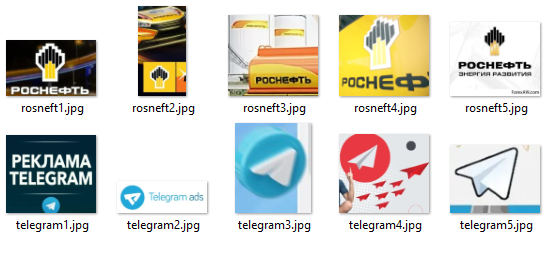

In [24]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import zipfile
import random
import matplotlib.pyplot as plt

In [2]:
with zipfile.ZipFile('logo.zip', 'r') as zip_ref:
    zip_ref.extractall('logos')

In [22]:
logo_folder = 'logos/logo'
output_folder = 'aug_logo'

# Папка для сохранения изображений
os.makedirs(output_folder, exist_ok=True)

# Изменение яркости
def change_brightness(image, beta_value):
    return cv2.convertScaleAbs(image, alpha=1, beta=beta_value)

# Создание плохих кадров с полосками
def create_bad_frames(image):
    h, w = image.shape[:2]
    for _ in range(10):  # Количество полосок
        x1, y1 = random.randint(0, w), random.randint(0, h)
        x2, y2 = random.randint(0, w), random.randint(0, h)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.line(image, (x1, y1), (x2, y2), color, thickness=random.randint(1, 3))
    return image

# Добавление водяного знака
def add_watermark(image, watermark_text):
    overlay = image.copy()
    cv2.putText(overlay, watermark_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return cv2.addWeighted(overlay, 0.5, image, 0.5, 0)

# Добавления блюра
def add_blur(image):
    return cv2.GaussianBlur(image, (15, 15), 0)

# Название компаний на разном фоне
def create_text_image(company_name, background_color, text_color):
    font = ImageFont.load_default() # можно поменять шрифт
    image = Image.new('RGB', (200, 50), background_color)
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), company_name, font=font, fill=text_color)
    return np.array(image)

# Афинное преобразование
def affine_transform(image):
    rows, cols, _ = image.shape
    pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
    pts2 = np.float32([[10, 100], [200, 50], [100, 250]])
    M = cv2.getAffineTransform(pts1, pts2)
    return cv2.warpAffine(image, M, (cols, rows))

# Поворот изображения
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

for root, dirs, files in os.walk(logo_folder):
    for dir_name in dirs:
        company_name = dir_name
        dir_path = os.path.join(root, dir_name)

        # Создание текстовых изображений на черном и белом фоне (только один раз для каждой компании)
        text_image_white = create_text_image(company_name, (255, 255, 255), (0, 0, 0))
        text_image_black = create_text_image(company_name, (0, 0, 0), (255, 255, 255))
        cv2.imwrite(os.path.join(output_folder, f'text_white_{company_name}.png'), text_image_white)
        cv2.imwrite(os.path.join(output_folder, f'text_black_{company_name}.png'), text_image_black)

        for filename in os.listdir(dir_path):
            if filename.endswith('.png') or filename.endswith('.jpg'):
                image_path = os.path.join(dir_path, filename)
                image = cv2.imread(image_path)

                # Поворот изображения перед каждым преобразованием
                angles = [random.randint(-45, 45) for _ in range(6)]  # Случайные углы поворота для каждого преобразования

                # 1. Яркость
                rotated_image = rotate_image(image, angles[0])
                brightness_value = random.choice([-50, 50])  # Случайное изменение яркости
                bright_image = change_brightness(rotated_image, brightness_value)
                cv2.imwrite(os.path.join(output_folder, f'bright_{filename}'), bright_image)

                # 2. Плохие кадры
                rotated_image = rotate_image(image, angles[1])
                bad_frames_image = create_bad_frames(rotated_image)
                cv2.imwrite(os.path.join(output_folder, f'bad_frames_{filename}'), bad_frames_image)

                # 3. Водяные знаки компании
                rotated_image = rotate_image(image, angles[2])
                watermarked_image = add_watermark(rotated_image, company_name)
                cv2.imwrite(os.path.join(output_folder, f'watermarked_{filename}'), watermarked_image)

                # 4. Блюр
                rotated_image = rotate_image(image, angles[3])
                blurred_image = add_blur(rotated_image)
                cv2.imwrite(os.path.join(output_folder, f'blurred_{filename}'), blurred_image)

                # 6. Афинное преобразование
                rotated_image = rotate_image(image, angles[4])
                affine_image = affine_transform(rotated_image)
                cv2.imwrite(os.path.join(output_folder, f'affine_{filename}'), affine_image)

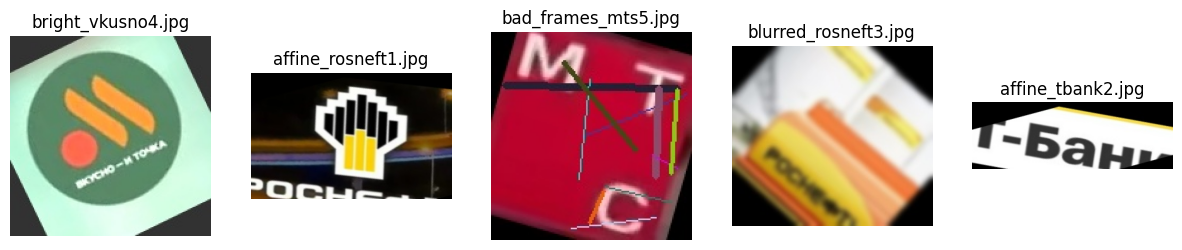

In [29]:
all_files = [f for f in os.listdir(output_folder) if f.endswith(('.png', '.jpg'))]

random_images = random.sample(all_files, min(5, len(all_files)))

plt.figure(figsize=(15, 10))
for i, image_name in enumerate(random_images, 1):
    image_path = os.path.join(output_folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)

plt.show()

In [30]:
def create_zip(folder_path, zip_name):
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

create_zip(output_folder, 'augmented_logo.zip')
# create_zip(logo_folder, 'main_logo.zip')

# Результат:
В результате я получил 324 новых изображений, которые я добавлю в основную папку, но перед этим уберу нерепрезентативные изображения.

Например: VK и telegram могут иметь черные(пустые) сцены, которые в будущем могут понизить точность